In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("/home1/smaruj/akitaX1-analyses/plot_styles/global_plotting_style.mplstyle")

from scipy.stats import pearsonr, spearmanr
import bioframe
import bbi
import pingouin as pg

import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import read_disruption_smf_data

In [2]:
# directory with data
data_dir = "/project/fudenber_735/akitaX1_analyses_data/genomic_disruption/disruptions_vs_features/"

In [3]:
df_ave = read_disruption_smf_data(data_dir)

In [4]:
# data with the SMF experiment results
binding_frequencies = pd.read_table("/home1/smaruj/akitaX1-analyses/input_data/sonmezer2021_SMF_CTCF_binding_data/binding.frequencies.tsv",sep="\t")

In [ ]:
# import matplotlib.pyplot as plt

# # Assuming binding_frequencies is your DataFrame and is already defined

# # Filter the DataFrame for rows where the biological state is "Bound" and select the "Freqs" column
# bound_freqs = binding_frequencies[binding_frequencies["biological.state"] == "Bound"]["Freqs"]

# # Create the histogram
# plt.figure(figsize=(10, 6))
# plt.hist(bound_freqs, bins=20, color='skyblue', edgecolor='black')

# # Adding labels and title
# plt.xlabel('Frequency', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.title('Histogram of Binding Frequencies for "Bound" Biological State', fontsize=14)

# plt.show()

In [5]:
# merging data based on the TFBS_cluster
df = df_ave.merge(binding_frequencies[binding_frequencies["biological.state"] == "Accessible"][["TFBS_cluster", "Freqs"]], on=["TFBS_cluster"], how="left")
df = df.rename(columns={"Freqs": "freq_accessible"})
df = df.merge(binding_frequencies[binding_frequencies["biological.state"] == "Bound"][["TFBS_cluster", "Freqs"]], on=["TFBS_cluster"], how="left")
df = df.rename(columns={"Freqs": "freq_bound"})

In [6]:
df.fillna(0, inplace=True)

In [7]:
seq_coords_df_expaned = bioframe.expand(bioframe.expand(df, scale=0),pad=100)

In [8]:
# adding ChIP-seq data

chip_dict = {
'justice_2020_CTCF':'/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_CTCF-ChIPseq.bw',
'hansen_2019_CTCF':'/project/fudenber_735/GEO/hansen_2019_GSE123636/mm10/GSM3508478_C59_CTCF.bw',
'justice_2020_Rad21':'/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_Rad21-ChIPseq.bw',
'hansen_2017_Rad21':'/project/fudenber_735/GEO/hansen_2017_GSE90994/mm10/GSM2418859_WT_Rad21.bw'
}

for chip in chip_dict:
    print('calculating ',chip)
    with bbi.open( chip_dict[chip] ) as BBIFile:
        chip_values = BBIFile.stackup(
                        seq_coords_df_expaned['chrom'], 
                        seq_coords_df_expaned['start'], 
                        seq_coords_df_expaned['end'], 
                        bins=1, summary='sum')
    df[chip] = chip_values
    
print('done')

calculating  justice_2020_CTCF
calculating  hansen_2019_CTCF
calculating  justice_2020_Rad21
calculating  hansen_2017_Rad21
done


In [ ]:
# df.columns

In [ ]:
# sns.scatterplot(data=df, x='justice_2020_CTCF', y='SCD', hue='freq_bound', alpha=0.7)

In [ ]:
# sns.scatterplot(data=df, x='justice_2020_Rad21', y='SCD', hue='freq_bound', alpha=0.7)

In [ ]:
# sns.scatterplot(data=df, x='phyloP', y='SCD', hue='freq_bound', alpha=0.5)

In [ ]:
# sns.scatterplot(data=df, x='PWM_score', y='SCD', hue='freq_bound', alpha=0.5)

In [ ]:
# sns.scatterplot(data=df, x='freq_bound', y='SCD', hue='justice_2020_CTCF', alpha=0.7)

In [ ]:
# sns.scatterplot(data=df, x='freq_bound', y='SCD', hue='hansen_2019_CTCF', alpha=0.7)

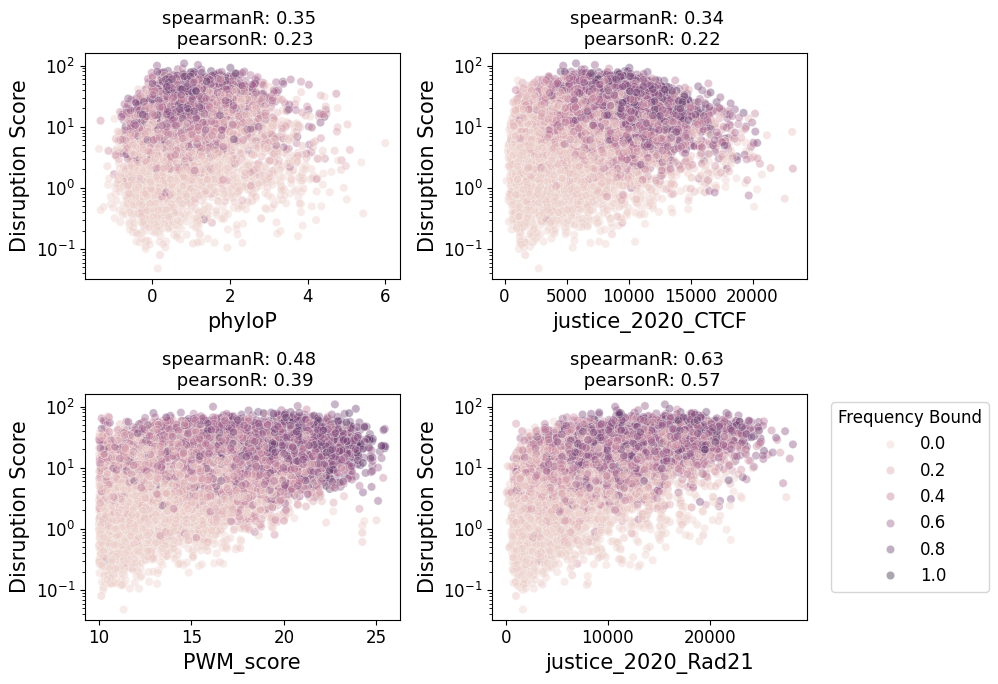

In [29]:
i = 0
plt.figure(figsize=(12, 7))
for key in ['phyloP', 'justice_2020_CTCF', 'PWM_score', "justice_2020_Rad21"]:
    i += 1
    plt.subplot(2, 2, i)
    
    # Plot without legend for the first three plots, and add legend only for the last plot
    if i < 4:
        sns.scatterplot(data=df, x=key, y='SCD', hue='freq_bound', alpha=0.4, legend=False)
    else:
        scatter = sns.scatterplot(data=df, x=key, y='SCD', hue='freq_bound', alpha=0.4)
        # For the last plot, generate the legend outside
        plt.legend(title='Frequency Bound', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.semilogy()
    plt.xlabel(key, fontsize=15)
    plt.ylabel('Disruption Score', fontsize=15)
    
    s = np.round(spearmanr(df[key], df['SCD'])[0], 2)
    p = np.round(pearsonr(df[key], df['SCD'])[0], 2)
    
    plt.title(f'spearmanR: {s} \n pearsonR: {p}')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("./plots/disruption_score_scatterplots.pdf", format="pdf", bbox_inches="tight")

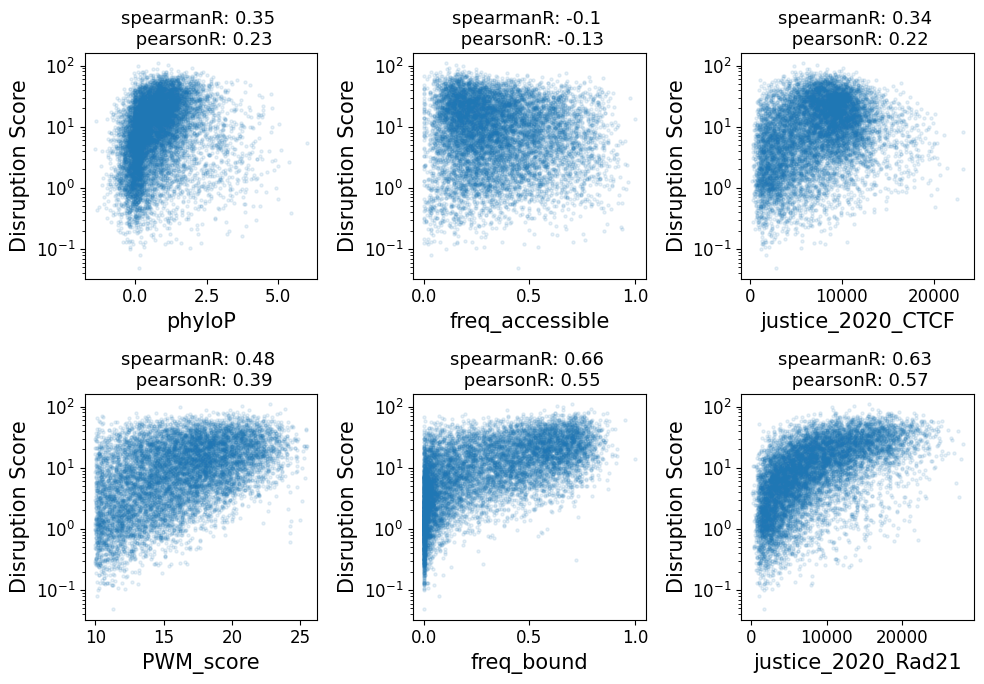

In [31]:
i = 0
plt.figure(figsize=(10,7))
for key in ['phyloP', 'freq_accessible', 'justice_2020_CTCF', 'PWM_score', 'freq_bound', "justice_2020_Rad21"]:
    i+=1
    #plt.figure(figsize=(4,3))
    plt.subplot(2,3,i)
    plt.scatter(df[key], df['SCD'], 5, alpha=0.1 )
    plt.semilogy()
    
    plt.xlabel(key, fontsize=15)  # Increase fontsize for x label
    plt.ylabel('Disruption Score', fontsize=15)  # Increase fontsize for y label

    
    s = np.round(spearmanr(df[key], df['SCD'], )[0] ,2)
    p = np.round(pearsonr(df[key], df['SCD'], )[0] ,2)
    
    plt.title(f'spearmanR: {s} \n pearsonR: {p}')#,str(s)

plt.tight_layout()
plt.savefig("./plots/disruption_score_scatterplots_alt.pdf", format="pdf", bbox_inches="tight")

In [17]:
# picking data for the next plots
sonmezer_stats = ["freq_accessible", "freq_bound", "phyloP", "PWM_score"] 
keys = ["SCD"] + sonmezer_stats + list(chip_dict.keys())

In [20]:
labels = ['Disruption Score',
 'freq_accessible',
 'freq_bound',
 'phyloP',
 'PWM_score',
 'justice_2020_CTCF',
 'hansen_2019_CTCF',
 'justice_2020_Rad21',
 'hansen_2017_Rad21']

Text(0, 0.5, 'correlation')

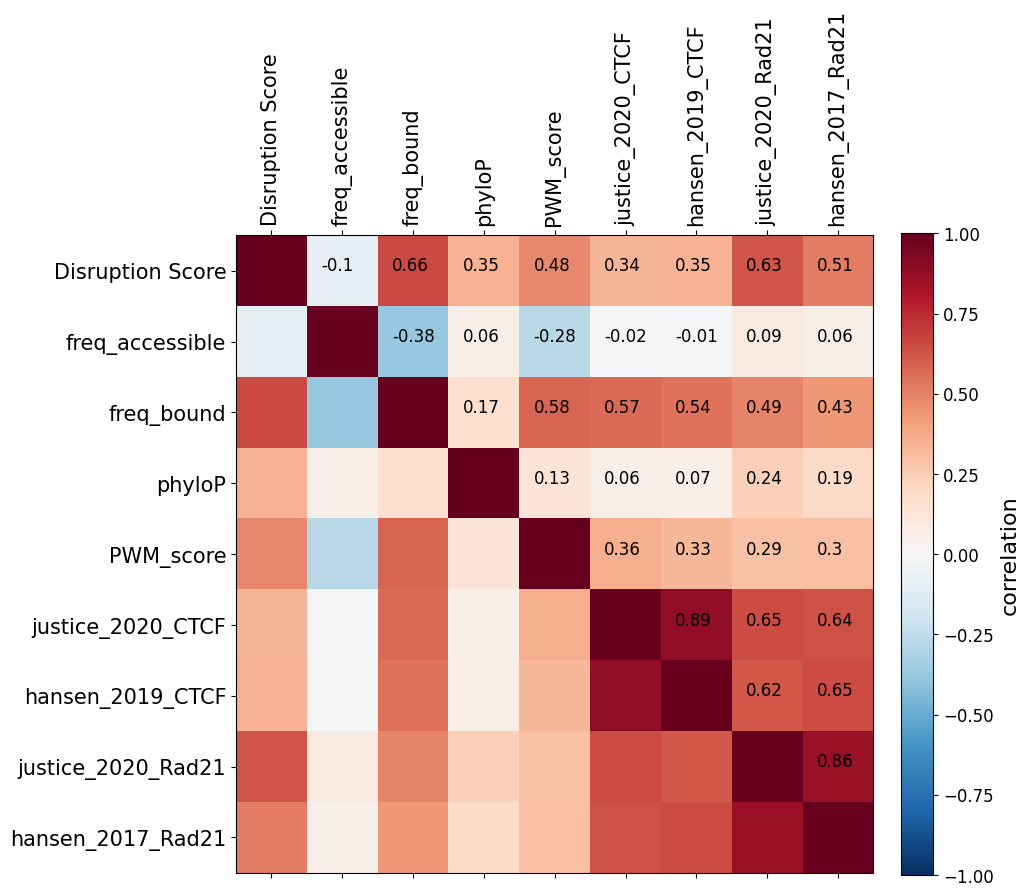

In [23]:
figwidth = 9
plt.figure(figsize=(figwidth,figwidth))

corr_mat = np.round(spearmanr(df[keys].values)[0],2)

plt.matshow(
    corr_mat,
    fignum=False,
    cmap='RdBu_r',
    vmin=-1,vmax=1

); 
for i in range(len(keys)):
    for j in range(len(keys)):
        if i <=j:continue
        plt.text( i - 0.3 ,j,  str(corr_mat[i,j]),
                   color='k',fontsize=12 )
        
plt.xticks(np.arange(len(keys)), labels, rotation=90, fontsize=15)
plt.yticks(np.arange(len(keys)), labels, fontsize=15)

cbar = plt.colorbar(label='correlation', fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('correlation', rotation=90, fontsize=16)
# plt.savefig("./plots/disruption_score_correlation_matrix.pdf", format="pdf", bbox_inches="tight")

# Partial Correlation

In [24]:
partial_correlation_1_keys = ["SCD", "freq_bound", "justice_2020_CTCF", "justice_2020_Rad21"]
partial_correlation_2_keys = ["SCD", "freq_bound", "hansen_2019_CTCF", "hansen_2017_Rad21"]

In [ ]:
# partial_correlation_1_keys = ["freq_bound", "justice_2020_CTCF"]
# partial_correlation_2_keys = ["freq_bound", "hansen_2019_CTCF"]

In [ ]:
"phyloP", "PWM_score"

In [25]:
partial_correlation_1_keys = ["SCD", "freq_bound", "phyloP", "PWM_score", "justice_2020_CTCF", "justice_2020_Rad21"]
partial_correlation_2_keys = ["SCD", "freq_bound", "phyloP", "PWM_score", "hansen_2019_CTCF", "hansen_2017_Rad21"]

In [26]:
corr_mat_1 = df[partial_correlation_1_keys].pcorr().round(3).values

In [ ]:
# This method computes pairwise partial correlations of all variables in the DataFrame, controlling for all other variables in each calculation.

In [27]:
corr_mat_2 = df[partial_correlation_2_keys].pcorr().round(3).values

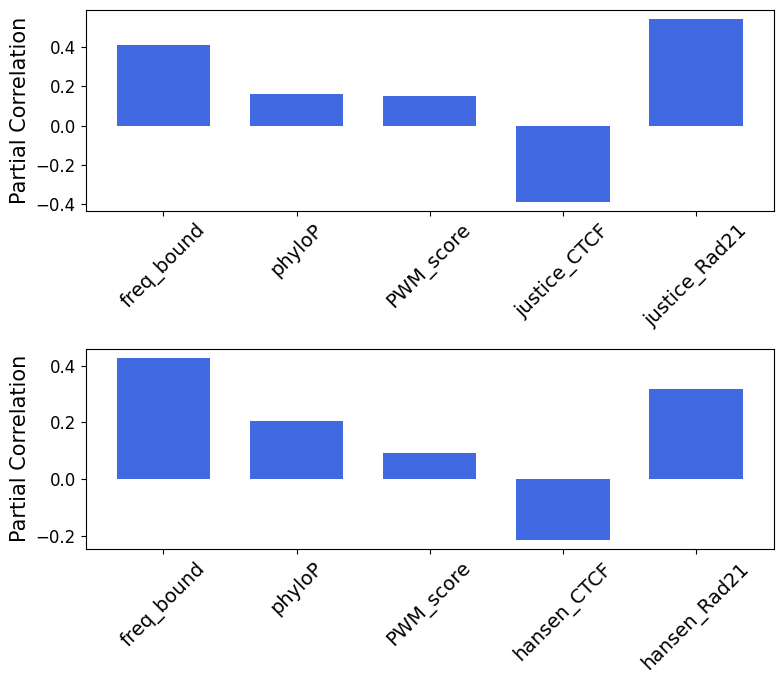

In [28]:
values1 = [corr_mat_1[0, 1], corr_mat_1[0, 2], corr_mat_1[0, 3], corr_mat_1[0, 4], corr_mat_1[0, 5]]
x_labels1 = ["freq_bound", "phyloP", "PWM_score", "justice_CTCF", "justice_Rad21"]

values2 = [corr_mat_2[0, 1], corr_mat_2[0, 2], corr_mat_2[0, 3], corr_mat_2[0, 4], corr_mat_2[0, 5]]
x_labels2 = ["freq_bound", "phyloP", "PWM_score", "hansen_CTCF", "hansen_Rad21"]

# Setting up the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 7))  # 2 rows, 1 column

# Plotting the first set of data on the first subplot
axes[0].bar(x_labels1, values1, width=0.7, color="royalblue")
axes[0].set_ylabel('Partial Correlation', fontsize=15)
axes[0].tick_params(axis='x', labelsize=14, rotation=45)

# Plotting the second set of data on the second subplot
axes[1].bar(x_labels2, values2, width=0.7, color="royalblue")
axes[1].set_ylabel('Partial Correlation', fontsize=15)
axes[1].tick_params(axis='x', labelsize=14, rotation=45)

plt.tight_layout()

# plt.savefig("./plots/disruption_score_partial_corelations.pdf", format="pdf")

plt.tight_layout()  # Adjust layout
plt.show()

In [ ]:
# values1 = [corr_mat_1[0, 1], corr_mat_1[0, 2], corr_mat_1[0, 3], corr_mat_1[0, 4], corr_mat_1[0, 5]]
# x_labels1 = ["freq_bound", "phyloP", "PWM_score", "Justice_CTCF", "Justice_Rad21"]

# # Setting up the figure and subplots
# fig, axes = plt.subplots(1, 1, figsize=(10, 6))  # 2 rows, 1 column

# # Plotting the first set of data on the first subplot
# axes.bar(x_labels1, values1, width=0.7, color="royalblue")
# axes.set_ylabel('Partial Correlation', fontsize=15)
# axes.tick_params(axis='x', labelsize=14, rotation=45)
# # axes.set_xlabel("", labelpad=120)

# plt.tight_layout()

# # plt.savefig("./plots/disruption_score_partial_corelations_Justice.pdf", format="pdf")

# plt.show()

In [ ]:
# values = [corr_mat_1[0, 1], corr_mat_1[0, 2], corr_mat_1[0, 3], corr_mat_1[0, 4], corr_mat_1[0, 5]]
# x_labels = ["freq_bound", "phyloP", "PWM_score", "Justice_CTCF", "Justice_Rad21"]

# # Creating the bar plot
# plt.figure(figsize=(9, 6))
# bars = plt.bar(x_labels, values, width=0.7, color="royalblue")

# # Adding the y-axis label
# plt.ylabel('Partial Correlation', fontsize=15)

# # Adjust the size of the x-axis labels
# plt.xticks(fontsize=12, rotation=45)  # Change 12 to your desired size

# # # Optionally, add value labels on top of each bar
# # for bar in bars:
# #     yval = bar.get_height()
# #     if yval >= 0:
# #         label_position = yval + 0.01  # Positive values
# #         va = 'bottom'
# #     else:
# #         label_position = yval - 0.01  # Negative values
# #         va = 'top'
# #     plt.text(bar.get_x() + (bar.get_width() / 2.0), label_position, round(yval, 2), va=va, ha='center')

# # plt.savefig("./plots/disruption_score_partial_corelations_Justice.pdf", format="pdf")

# plt.tight_layout()  # Adjust layout
# plt.show()

In [ ]:
values = [corr_mat_2[0, 1], corr_mat_2[0, 2], corr_mat_2[0, 3], corr_mat_2[0, 4], corr_mat_2[0, 5]]
x_labels = ["freq_bound", "phyloP", "PWM_score", "hansen_2019_CTCF", "hansen_2017_Rad21"]

# Creating the bar plot
plt.figure(figsize=(9, 4))
bars = plt.bar(x_labels, values, width=0.7)

# Adding the y-axis label
plt.ylabel('Partial Correlation', fontsize=15)

# Adjust the size of the x-axis labels
plt.xticks(fontsize=12, rotation=70)  # Change 12 to your desired size

# # Optionally, add value labels on top of each bar
# for bar in bars:
#     yval = bar.get_height()
#     if yval >= 0:
#         label_position = yval  # Positive values
#         va = 'bottom'
#     else:
#         label_position = yval  # Negative values
#         va = 'top'
#     plt.text(bar.get_x() + bar.get_width() / 2.0, label_position, round(yval, 2), va=va, ha='center')

plt.show()

In [ ]:
pg.partial_corr(data=df[partial_correlation_1_keys], x='SCD', y='freq_bound', covar=["justice_2020_CTCF", "justice_2020_Rad21", "phyloP", "PWM_score"])

In [ ]:
pg.partial_corr(data=df[partial_correlation_1_keys], x='SCD', y='justice_2020_CTCF', covar=["freq_bound", "justice_2020_Rad21", "phyloP", "PWM_score"])

In [ ]:
pg.partial_corr(data=df, x="SCD", y=["justice_2020_CTCF"])

In [ ]:
pg.partial_corr(data=df, x="SCD", y=["freq_bound"])

In [ ]:
pg.partial_corr(data=df, x="SCD", y=["justice_2020_Rad21"])

In [ ]:
pg.partial_corr(data=df, x="SCD", y=["phyloP"])

In [ ]:
pg.partial_corr(data=df, x="SCD", y=["PWM_score"])